In [ ]:
# default_exp experiments.auto

In [ ]:
#export
import numpy as np
import pandas as pd
import neuralforecast as nf
from hyperopt import hp

In [ ]:
#export
def auto(config_dict: dict, 
         Y_df: pd.DataFrame, X_df: pd.DataFrame, S_df: pd.DataFrame,
         loss_function_val: callable, loss_functions_test: dict, 
         forecast_horizon: int, ts_in_val: int, ts_in_test: int,
         return_forecasts: bool = False, return_model: bool = True, 
         test_auto: bool = False, verbose: bool = False):
    """
    Auto hyperparameter tuning function.

    Parameters
    ----------
    config_dict: Dict
        Dictionary with configuration. Keys should be name of models.
        For each model specify the hyperparameter space 
        (None will use default suggested space), hyperopt steps and timeout.
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    X_df: pd.DataFrame
        Exogenous time series with columns ['unique_id', 'ds', 'y'].
    S_df: pd.DataFrame
        Static exogenous variables with columns ['unique_id', 'ds']. 
        and static variables. 
    loss_function_val: function
        Loss function used for validation.
    loss_functions_test: Dictionary
        Loss functions used for test evaluation. 
        (function name: string, function: fun)
    forecast_horizon: int
        Forecast horizon
    ts_in_val: int
        Number of timestamps in validation.
    ts_in_test: int
        Number of timestamps in test.
    return_forecasts: bool
        If true return forecast on test.
    return_model: bool
        If true return model.
    test_auto: bool
        If true, will only run one training step and hyperopt iteration for each model. 
        For testing purposes, to ensure your pipeline will finish running, without waiting.
    verbose:
        If true, will print summary of dataset, model and training.
    """

    if test_auto:
        print('WARNING: test_auto=True, MODELS WILL NOT BE TRAINED PROPERLY!')

    # Data characteristics
    n_series = Y_df['unique_id'].nunique()
    n_x = len(X_df.columns)-2 if X_df is not None else 0
    n_s = len(S_df.columns)-1 if S_df is not None else 0
    frequency = pd.infer_freq(Y_df['ds'])

    # Hyperopt
    models = config_dict.keys()
    output_dict = {}
    best_model = None
    best_loss = np.inf
    for model in models:
        model_config = config_dict[model]

        hyperopt_steps = model_config['hyperopt_steps'] if (test_auto==False) else 1

        if model_config['space'] is None:
            # If hyperparameter space is None, use predefined space for the model
            # Available spaces, [N-BEATS, N-HiTS, RNN]
            space = instantiate_space(model=model, n_time_out=forecast_horizon, 
                                      n_series=n_series, n_x=n_x, n_s=n_s, 
                                      frequency=frequency, test=test_auto)
        else:
            space = model_config['space']
        
        # Run automated hyperparameter optimization
        trials = nf.experiments.utils.hyperopt_tunning(space=space,
                                                       hyperopt_max_evals=hyperopt_steps,
                                                       loss_function_val=loss_function_val,
                                                       loss_functions_test=loss_functions_test,
                                                       S_df=S_df, Y_df=Y_df, X_df=X_df, 
                                                       f_cols=[], ds_in_val=ts_in_val, 
                                                       ds_in_test=ts_in_test,
                                                       return_forecasts=return_forecasts,
                                                       return_model=return_model,
                                                       save_progress=False,
                                                       results_file=None,
                                                       step_save_progress=0,
                                                       verbose=verbose)

        model_output = {'best_mc': trials.best_trial['result']['mc'],
                        'run_time': trials.best_trial['result']['run_time'],
                        'best_val_loss': trials.best_trial['result']['loss']}

        # Return model
        if return_model:
            model_output['model'] = trials.best_trial['result']['model']

        # Return test losses
        if ts_in_test > 0:
            model_output['best_test_loss'] = trials.best_trial['result']['test_losses']

        # Return test forecasts
        if (return_forecasts) and (ts_in_test > 0):
            model_output['y_hat'] = trials.best_trial['result']['forecasts_test']['test_y_hat']
            model_output['y_true'] = trials.best_trial['result']['forecasts_test']['test_y_true']

        # Improvement
        optimization_times = [trials.trials[0]['result']['loss']]
        optimization_losses = [trials.trials[0]['result']['run_time']]
        for i in range(1, len(trials)):
            loss = trials.trials[i]['result']['loss']
            time = trials.trials[i]['result']['run_time']

            if loss > np.min(optimization_losses):
                loss = np.min(optimization_losses)
            optimization_losses.append(loss)
            optimization_times.append(np.sum(optimization_times)+time)

        model_output['optimization_losses'] = optimization_losses
        model_output['optimization_times'] = optimization_times
    
        # Append to dict
        output_dict[model] = model_output

        if trials.best_trial['result']['loss'] < best_loss:
            best_model = trials.best_trial['result']['model']
            best_loss = trials.best_trial['result']['loss']

    return best_model, output_dict

In [ ]:
#export
def instantiate_space(model, n_time_out, n_series, n_x, n_s, frequency, test):
    assert model in ['nbeats', 'nhits', 'rnn'], f'Invalid model {model}'
    
    if model == 'nbeats':
        space = nf.models.nbeats.nbeats.suggested_space(n_time_out=n_time_out, n_series=n_series, 
                                                        n_x=n_x, n_s=n_s, frequency=frequency)
    elif model == 'nhits':
        space = nf.models.nhits.nhits.suggested_space(n_time_out=n_time_out, n_series=n_series, 
                                                      n_x=n_x, n_s=n_s, frequency=frequency)
    elif model == 'rnn':
        space = nf.models.rnn.rnn.suggested_space(n_time_out=n_time_out, n_series=n_series,
                                                  n_x=n_x, n_s=n_s, frequency=frequency)

    if test:
        space['max_steps'] = hp.choice('max_steps', [1])
        space['max_epochs'] = hp.choice('max_epochs', [None])
    
    return space

## AutoNF example

The forecasting task we selected is to predict the number of patients with influenza-like illnesses from the [US CDC dataset](https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html), the dataset contains 7 target variables, and has 966 weeks of history.

We will be creating point forecasts with N-BEATS, N-HiTS and RNN models. The predictive features will be the autoregressive features. More information on the dataset can be found in the [N-HiTS paper](https://arxiv.org/abs/2201.12886).

Table of Contents
1.   [Installing NeuralForecast Library](#cell-1)
2.   [Data Loading and Processing](#cell-2)
3.   [Define Hyperparameter Space](#cell-3)
4.   [Hyperparameter Tuning](#cell-4)
5.   [Evaluate Results](#cell-5)

<a name="cell-1"></a>
### 1. Installing Neuralforecast library

You can install the released version of NeuralForecast from the Python package index with:

In [ ]:
#%%capture
#!pip install neuralforecast
#!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt

from neuralforecast.data.datasets.long_horizon import LongHorizon

<a name="cell-2"></a>
### 2. Data Loading and Processing

For this example we keep 10% of the observations as validation and use the latest 20% of the observations as the test set. To do so we use the sample_mask and declare the windows that will be used to train, and validate the model.

In [ ]:
Y_df, _, _ = LongHorizon.load(directory='./', group='ILI')
Y_df.head()

,unique_id,ds,y
0,% WEIGHTED ILI,2002-01-01,-0.421499
1,% WEIGHTED ILI,2002-01-08,-0.331239
2,% WEIGHTED ILI,2002-01-15,-0.342763
3,% WEIGHTED ILI,2002-01-22,-0.199782
4,% WEIGHTED ILI,2002-01-29,-0.218426


In [ ]:
n_series = len(Y_df.unique_id.unique())
n_time = len(Y_df.ds.unique()) # dataset is balanced

ts_in_test = 193
ts_in_val = 97

print('n_time', n_time)
print('n_series', n_series)
print('ts_in_test', ts_in_test)
print('ts_in_val', ts_in_val)

n_time 966
n_series 7
ts_in_test 193
ts_in_val 97


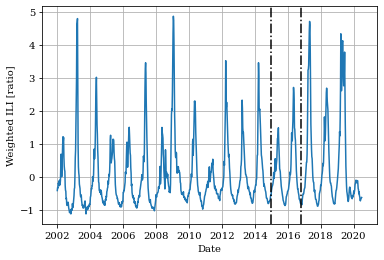

In [ ]:
# unique_id \in ['% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4', 
#                'AGE 5-24', 'ILITOTAL', 'NUM. OF PROVIDERS', 'OT']
y_plot = Y_df[Y_df.unique_id=='% WEIGHTED ILI'].y.values
x_plot = pd.to_datetime(Y_df[Y_df.unique_id=='% WEIGHTED ILI'].ds).values

plt.plot(x_plot, y_plot)
plt.axvline(x_plot[n_time-ts_in_val-ts_in_test], color='black', linestyle='-.')
plt.axvline(x_plot[n_time-ts_in_test], color='black', linestyle='-.')
plt.ylabel('Weighted ILI [ratio]')
plt.xlabel('Date')
plt.grid()
plt.show()
plt.close()

<a name="cell-3"></a>
### 3. Define Hyperparameter Space

A temporal train-evaluation split procedure allows us to estimate the model’s generalization performance on future data unseen by the model. We use the train set to optimize the model parameters, and the validation  and test sets to evaluate the accuracy of the model’s predictions.

In this case we set the space to `None`, that implicitly uses the predefined model space, but the space can be specified as a dictionary following the conventions of the [Hyperopt package](https://github.com/hyperopt/hyperopt).

In [ ]:
config_dict = {'nbeats':
                       {'space': None, # Use default
                        'hyperopt_steps': 5,
                        'timeout': 60*1
                       },
               'nhits':
                       {'space': None,  # Use default
                        'hyperopt_steps': 5,
                        'timeout': 60*1
                       },
                'rnn':
                       {'space': None,  # Use default
                        'hyperopt_steps': 5,
                        'timeout': 60*1
                       }
              }

<a name="cell-4"></a>
### 4. Hyperparameter Tuning

A temporal train-validation-test (676,97,193) split procedure allows us to estimate the model’s generalization performance on future data unseen by the model. We use the train set to optimize the model parameters, and the validation  and test sets to evaluate the accuracy of the model’s predictions.

In [ ]:
forecast_horizon = 24
best_model, results = auto(config_dict=config_dict,
                           Y_df=Y_df, X_df=None, S_df=None,
                           loss_function_val=nf.losses.numpy.mae, 
                           loss_functions_test={'mae':nf.losses.numpy.mae,
                                                'mse':nf.losses.numpy.mse},
                           forecast_horizon=forecast_horizon, ts_in_val=ts_in_val, ts_in_test=ts_in_test,
                           return_forecasts=True, return_model=True,
                           test_auto=True,
                           verbose=False)

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011241 seconds
INFO:hyperopt.tpe:TPE using 0 trials


/Users/kingtzolivares/Desktop/neuralforecast/neuralforecast/data/tsdataset.py:207: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)
INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/anaconda3/envs/neuralforecast/li

Text(0, 0.5, 'val loss')

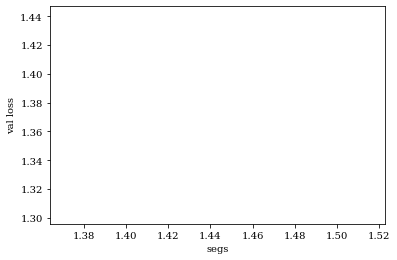

In [ ]:
time   = results['nbeats']['optimization_times']
losses = results['nbeats']['optimization_losses']
plt.plot(time, losses)
plt.xlabel('segs')
plt.ylabel('val loss')

<a name="cell-5"></a>
### 5. Evaluate Results

Here we wrangle the numpy predictions to evaluate and plot the predictions.

In [ ]:
y_hat_nhits  = results['nhits']['y_hat']#.reshape(n_series, forecast_horizon, ts_in_test)
y_hat_nbeats = results['nbeats']['y_hat']#.reshape(n_series, forecast_horizon, ts_in_test)
y_hat_rnn    = results['rnn']['y_hat']#.reshape(n_series, forecast_horizon, ts_in_test)
y_true       = results['nbeats']['y_true']#.reshape(forecast_horizon,n_series, -1)

print('\n Original Shapes')
print('1. y_hat_nhits.shape', y_hat_nhits.shape)
print('1. y_hat_nbeats.shape', y_hat_nbeats.shape)
print('1. y_hat_rnn.shape', y_hat_rnn.shape)
print('1. y_true.shape', y_true.shape)

y_hat_nbeats = results['nbeats']['y_hat'].reshape((74,#n_time//n_series,
                                                   n_series,forecast_horizon))
y_hat_nhits = results['nhits']['y_hat'].reshape((74,#n_time//n_series,
                                                  n_series,forecast_horizon))
y_true = results['nbeats']['y_true'].reshape((74,#n_time//n_series,
                                              n_series,forecast_horizon))

print('\n Wrangled Shapes')
print('2. y_hat_nhits.shape', y_hat_nhits.shape)
print('2. y_hat_nbeats.shape', y_hat_nbeats.shape)
print('2. y_hat_rnn.shape', y_hat_rnn.shape)
print('2. y_true.shape', y_true.shape)


 Original Shapes
1. y_hat_nhits.shape (518, 24)
1. y_hat_nbeats.shape (518, 24)
1. y_hat_rnn.shape (7, 4, 24)
1. y_true.shape (518, 24)

 Wrangled Shapes
2. y_hat_nhits.shape (74, 7, 24)
2. y_hat_nbeats.shape (74, 7, 24)
2. y_hat_rnn.shape (7, 4, 24)
2. y_true.shape (74, 7, 24)


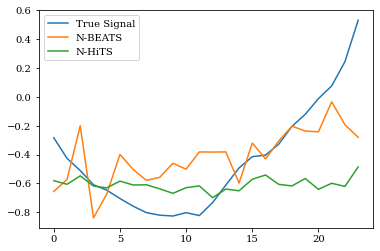

In [ ]:
w_idx = 0
u_idx = 0

plt.plot(y_true[w_idx,u_idx,:], label='True Signal')
plt.plot(y_hat_nbeats[w_idx,u_idx,:], label='N-BEATS')
plt.plot(y_hat_nhits[w_idx,u_idx,:], label='N-HiTS')
#plt.plot(y_true[:,0,2], label='True')
#plt.plot(best_nbeats[::24,:].flatten(), label='N-BEATS')
#plt.plot(best_rnn[::24,:].flatten(), label='RNN')
plt.legend()
plt.show()

Y_df.unique_id.unique() ['% WEIGHTED ILI' '%UNWEIGHTED ILI' 'AGE 0-4' 'AGE 5-24' 'ILITOTAL'
 'NUM. OF PROVIDERS' 'OT']


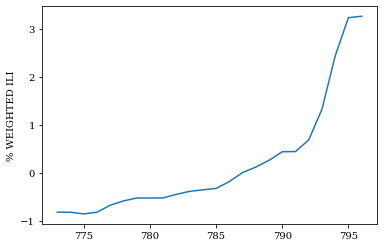

In [ ]:
print('Y_df.unique_id.unique()', Y_df.unique_id.unique())
ver = Y_df[Y_df.unique_id=='% WEIGHTED ILI']

plt.plot(ver.y[n_time-193:n_time-193+24])
plt.ylabel('% WEIGHTED ILI')
plt.show()

<a name="cell-5"></a>
### 5. Evaluate Results

In [ ]:
best_model

NHITS(
  (model): _NHITS(
    (blocks): ModuleList(
      (0): _NHITSBlock(
        (pooling_layer): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=True)
        (layers): Sequential(
          (0): Linear(in_features=8, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=1024, bias=True)
          (3): ReLU()
          (4): Linear(in_features=1024, out_features=1024, bias=True)
          (5): ReLU()
          (6): Linear(in_features=1024, out_features=121, bias=True)
        )
        (basis): _IdentityBasis()
      )
      (1): _NHITSBlock(
        (pooling_layer): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=True)
        (layers): Sequential(
          (0): Linear(in_features=15, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=1024, bias=True)
          (3): ReLU()
          (4): Linear(in_features=1024, out_features=1024, bias=

In [ ]:
# Y_forecast_df = Y_df[Y_df['ds']<'2016-12-27']
# X_forecast_df = X_df[X_df['ds']<'2016-12-28']

In [ ]:
# best_model.return_decomposition = False
# forecast_df = best_model.forecast(Y_df=Y_forecast_df, X_df=X_forecast_df, S_df=None, batch_size=2)
# forecast_df